# AdventureWorks Försäljningsanalys

I denna analys undersöker vi AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljning över tid
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Bananasplit1988!")
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")

connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde in ansluta", e)


Anslutning till SQL Server lyckades


C:\Users\Mauro\AppData\Local\Temp\ipykernel_26344\1129622301.py:24: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visulisering 1: Antal produkter per kategori

Hur många produkter finns i varje kategori?

Tabeller som använts:
- Production.ProductCategory, 
- Production.ProductSubcategory, 
- Production.Product

Plan:
- JOINA tabellerna
- Räkna DISTINCT produkter per kategori
- Skapa vertikalt stapeldiagram
- Analysera resultatet

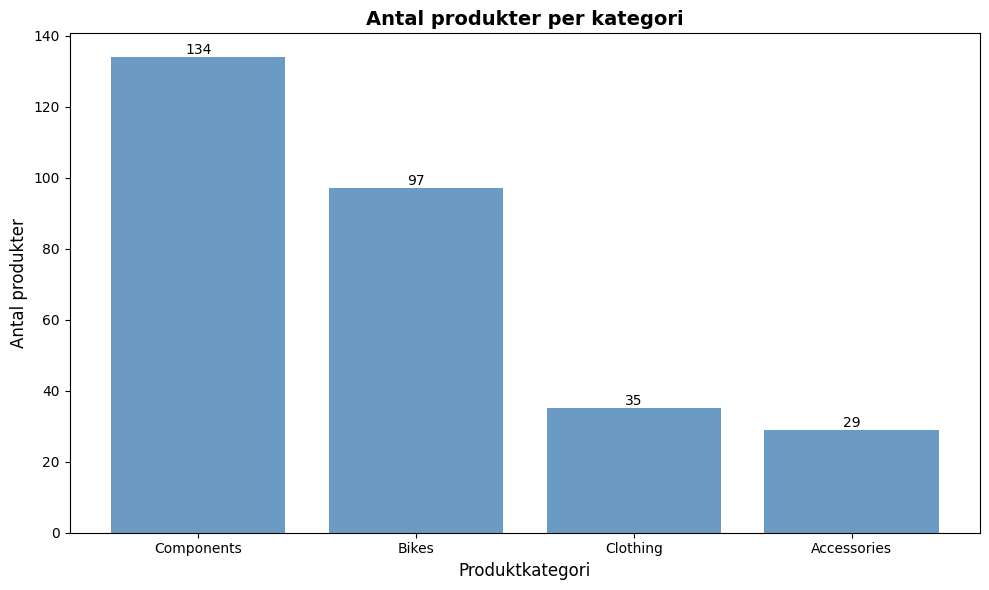

In [3]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""
df_vis1 = query_df(query_vis1)


fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color= 'steelblue', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

ax.set_xlabel('Produktkategori', fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12)
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight = 'bold')

plt.tight_layout()
plt.show()





### Insikter - Antal produkter per kategori
Components är största kategorin med 134 produkter.
Accessories är minst med 29 produkter.

Detta indikerar på att företaget är starkt fokuserad på komponenter och reservdelar. 
Ett potentiellt utvecklingsområde är kläder och accessoarer som är underrepresenterade här.

## Visulisering 2: Försäljning per produktkategori

Vilka produktkategorier genererar mest intäkter?

Tabeller som använts:
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

Plan:
- JOINA tabellerna
- Räkna försäljningstotal per kategori
- Skapa horisontellt stapeldiagram
- Analysera resultatet

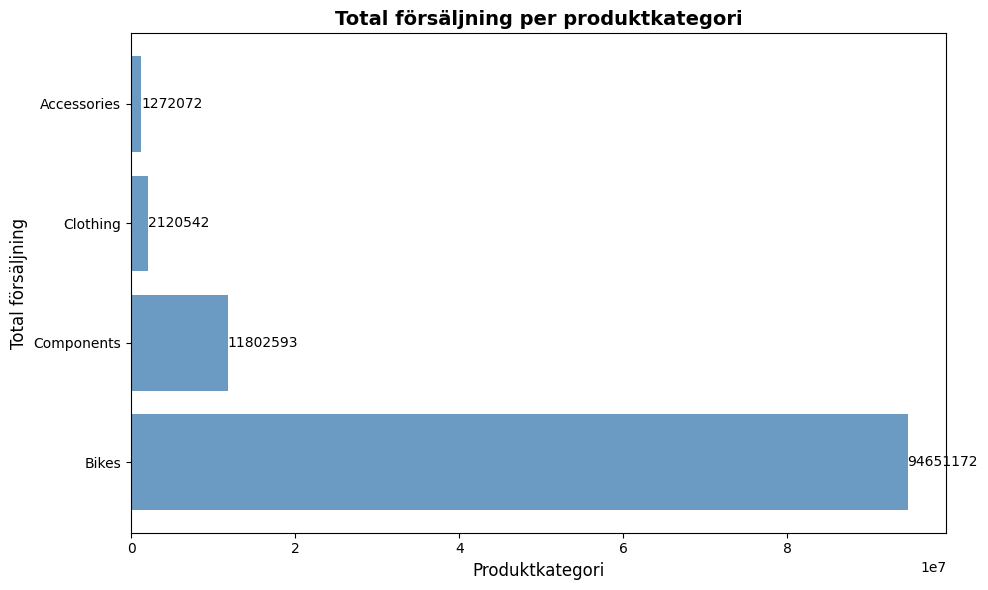

In [4]:
query_vis2 = """
SELECT 
    pc.Name AS CategoryName,
    SUM(so.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail so
    ON p.ProductID = so.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC;
"""
df_vis2 = query_df(query_vis2)


fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(df_vis2['CategoryName'], df_vis2['TotalSales'], color= 'steelblue', alpha=0.8)


for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f'{int(width)}',
        ha= 'left',
        va = 'center'
    )


ax.set_xlabel('Produktkategori', fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12)
ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight = 'bold')

plt.tight_layout()
plt.show()


### Insikter -  Försäljning per produktkategori
Bikes har högst försäljningssiffror på 94 651 172, följt av Components och Clothing.
Accessories ligger längst ner på listan med 1 272 072.


Företaget är starkt fokuserad på komponenter och reservdelar som tidigare stapeldiagram visade oss och det syns även på försäljningssiffrorna. 
Både Clothing och Accessories har stor utvecklingspotential. 

## Visulisering 3: Försäljningstrend över tid

Hur har försäljningen utvecklats över tid?

Använt följande tabell: Sales.SalesOrderHeader

Plan:
- Räkna totalförsäljning per månad
- Filtrera på försäljningssiffror från 2024
- Skapa linjediagram
- Analysera resultatet

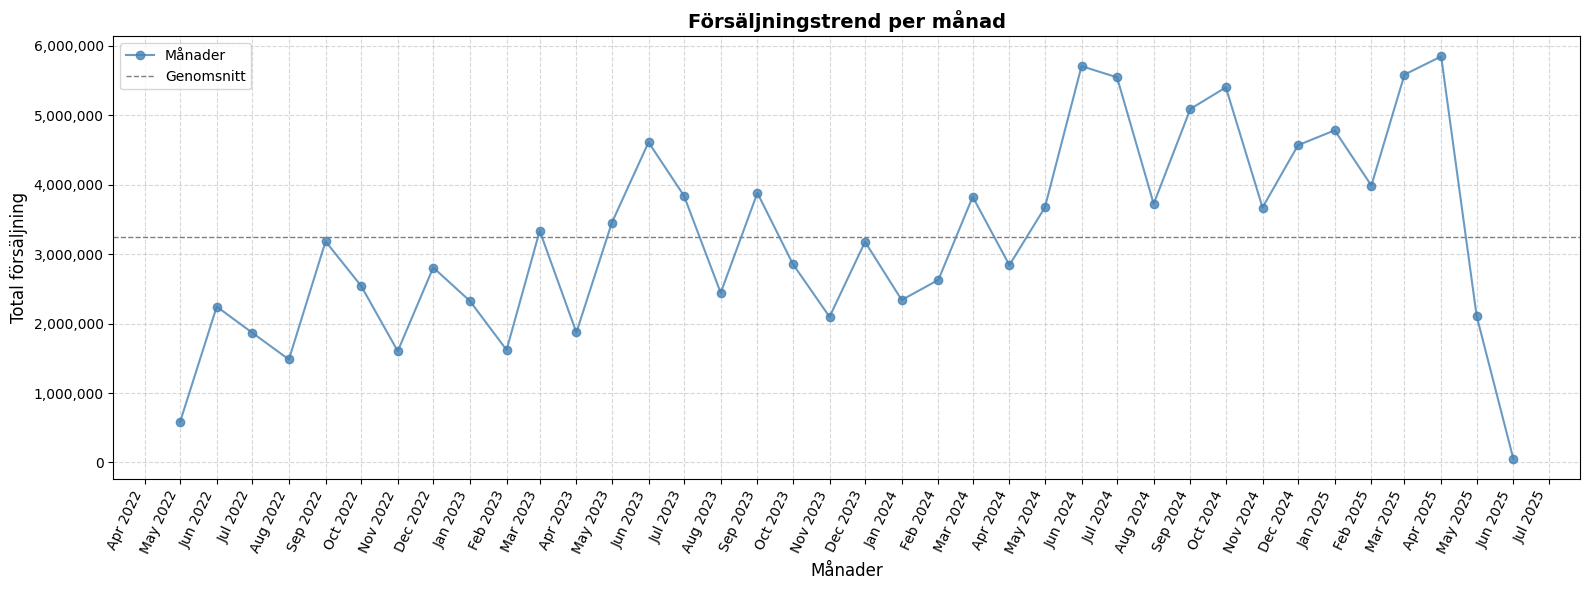

In [5]:
query_vis3 = """
SELECT
    CAST(FORMAT(OrderDate, 'yyyy-MM-01')AS date) AS MonthStart,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader soh
GROUP BY FORMAT(OrderDate, 'yyyy-MM-01')
ORDER BY MonthStart ASC;
"""
df_vis3 = query_df(query_vis3)


fig, ax = plt.subplots(figsize=(16,6))

ax.plot(df_vis3['MonthStart'], df_vis3['TotalSales'], marker='o', linestyle='-', color= 'steelblue', alpha=0.8, label= 'Månader')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=65)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'))

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Månader', fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12)
ax.set_title('Försäljningstrend per månad', fontsize=14, fontweight = 'bold')

avg_sales = df_vis3['TotalSales'].mean()
ax.axhline(avg_sales, color='gray', linestyle='--', linewidth=1, label='Genomsnitt')
ax.legend()

plt.tight_layout()
plt.show()

### Insikter - Försäljningstrend över tid
Linjen är ganska oregelbunden månad till månad men med en tendens att få dem högsta siffrorna i senare halvan av året.  Den högsta punkten sker i april 2025 på 5847164,69 men eftersom vi inte har datan för resten av 2025 kan vi inte jämföra med andra halvan av samma år. Den lägsta siffran ligger i augusti 2022 på 1483277,04. 
Med ett sådant ojämnt mönster i försäljningen är det svårt att följa påverkan eller inverkan. Djupare studier rekommenderas med fokus på regionala skillnader som en möjlig påverkan. 


## Visulisering 4: Försäljning och antal ordrar per år

Hur ser total försäljning och antal ordrar ut per år?

Använt följande tabell: Sales.SalesOrderHeader

Plan:
Räkna total antal ordrar samt total försäljning
Gruppera på år
Skapa grupperat stapeldiagram med .twinx() för att kunna visualisera antal ordrar ihop med total försäljning.
Analysera resultatet

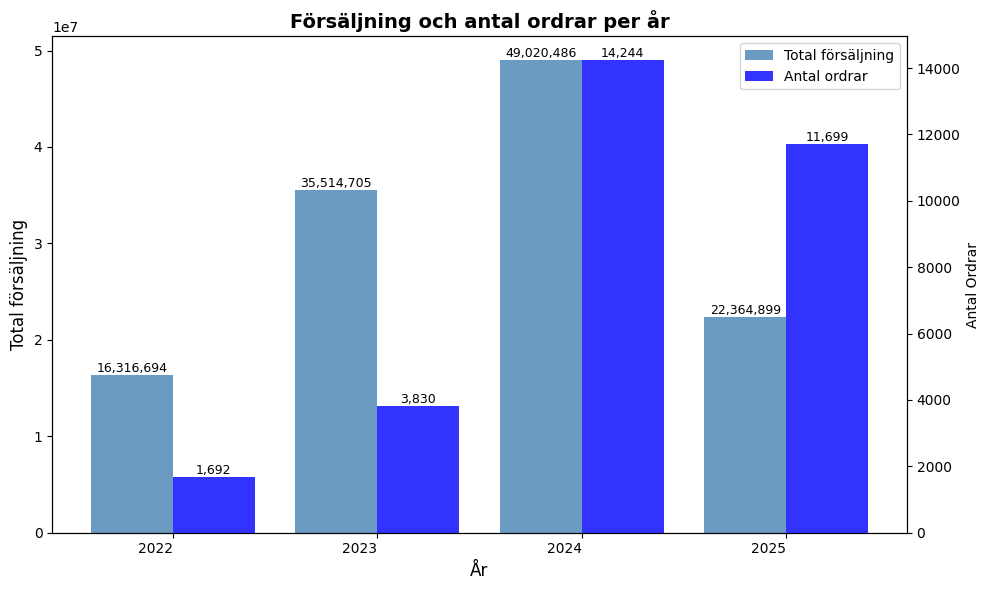

In [6]:
query_vis4 = """
SELECT
    DATEPART(year, OrderDate) AS SalesYear,
    SUM(TotalDue) AS TotalSales,
    COUNT(SalesOrderID) AS TotalOrders
FROM Sales.SalesOrderHeader
GROUP BY DATEPART(year, OrderDate)
ORDER BY DATEPART(year, OrderDate) ASC;
"""
df_vis4 = query_df(query_vis4)


fig, ax1 = plt.subplots(figsize=(10,6))
width = 0.40
x = df_vis4['SalesYear']

ax1.bar(df_vis4['SalesYear']-0.2, df_vis4['TotalSales'],width, color= 'steelblue', alpha=0.8, label='Total försäljning')

ax1.set_ylabel('Total försäljning', fontsize=12)
ax1.set_xlabel('År', fontsize=12)
ax1.set_title('Försäljning och antal ordrar per år', fontsize=14, fontweight = 'bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis4['SalesYear'], ha='right')

ax2 = ax1.twinx()

ax2.bar(df_vis4['SalesYear']+0.2, df_vis4['TotalOrders'], width, color= 'blue', alpha=0.8, label='Antal ordrar')
ax2.set_ylabel('Antal Ordrar')


for xi, val in zip(x - width/2, df_vis4['TotalSales']):
    ax1.text(
        xi, val, 
        f'{int(val):,}', 
        ha='center', 
        va='bottom', 
        fontsize=9
        )
    
for xi, val in zip(x + width/2, df_vis4['TotalOrders']):
    ax2.text(
        xi, val, 
        f'{int(val):,}',
        ha='center',
        va='bottom', 
        fontsize=9
        )


handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2)


plt.tight_layout()
plt.show()

### Insikter - Försäljning och antal ordrar per år

Om vi jämför försäljning mot antal ordrar är det svårt att se en exakt trend - 2022s siffror fördubblas nästan i 2023 men båda har väldigt låga antal ordrar i jämförelse med försäljningssiffrorna. Det dem 2 åren har i gemensamt är att ordrar ligger på 0.01% av försäljningen. 
2024 har dem högsta siffrorna både i försäljning och antal ordrar och ordrar ligger nu på 0.029% av försäljningsvärdet så mer billigare ordrar har gjorts.
2025 dras siffrorna ner igen men än konstigare är att ordervärde ligger nu på 0.05% av försäljningsvärdet. Orderantal har gått ner men inte i samma takt som försäljningen. Kan ha att göra med att vi inte fått in än alla siffror för detta år. 


## Visulisering 5: Top 10 produkter

Vilka 10 produkter genererar mest försäljning?

Tabeller som använts:
- Production.Product
- Sales.SalesOrderDetail

Plan:
- Välja Top 10
- JOINA tabellerna
- Räkna ut total försäljning
- Grupperna enligt kategori
- Skapa horisontellt stapeldiagram
- Analysera resultatet

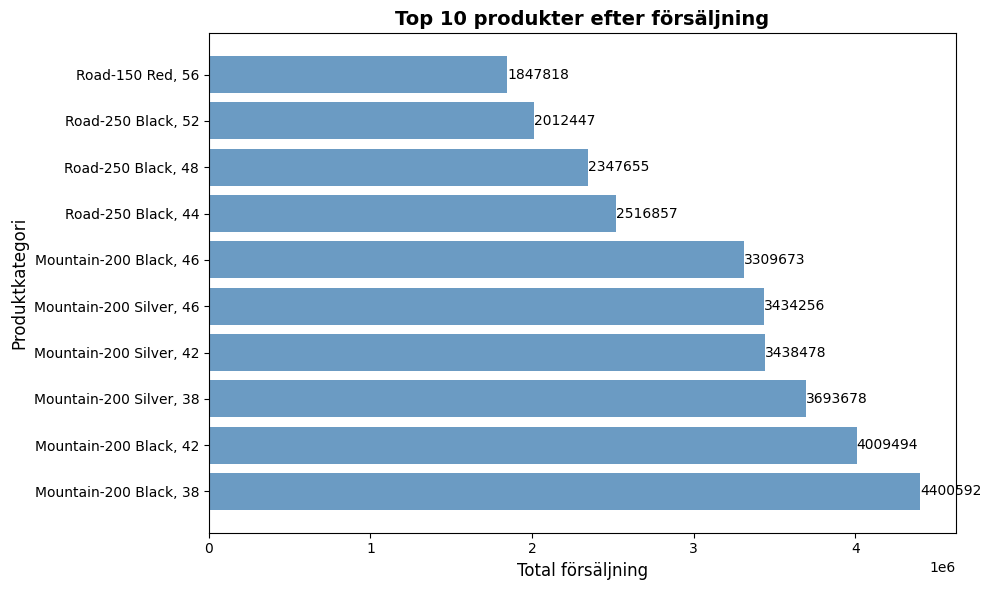

In [7]:
query_vis5 = """
SELECT TOP (10)
    p.Name AS ProductCategory,
    SUM(so.LineTotal) AS TotalSales    
FROM Production.Product p
INNER JOIN Sales.SalesOrderDetail so
    ON p.ProductID = so.ProductID
GROUP BY p.Name
ORDER BY SUM(so.LineTotal) DESC;
"""
df_vis5 = query_df(query_vis5)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(df_vis5['ProductCategory'], df_vis5['TotalSales'], color= 'steelblue', alpha=0.8)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f'{int(width)}',
        ha= 'left',
        va = 'center'
    )


ax.set_xlabel('Total försäljning', fontsize=12)
ax.set_ylabel('Produktkategori', fontsize=12)
ax.set_title('Top 10 produkter efter försäljning', fontsize=14, fontweight = 'bold')

plt.tight_layout()
plt.show()

### Insikter -  Vilka 10 produkter genererar mest försäljning?
I enlighet med företagets fokus så är dem top 10 kategorierna alla inom Bikes - den största säljaren är Mountain-200 Black, 38 med 4 400 592 i total försäljning.
Det är tydligt att Mountain kategorin säljer bäst eftersom den representerar 60% av dem top 10 produkterna. 

## Visulisering 6: Försäljning och antal kunder per region

Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Tabeller som använts:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer

Plan:
- JOINA tabellerna
- Räkna ut antal kunder
- Summera ihop total försäljning
- Skapa grupperat stapeldiagram med hjälp av twinx().
- Analysera resultatet

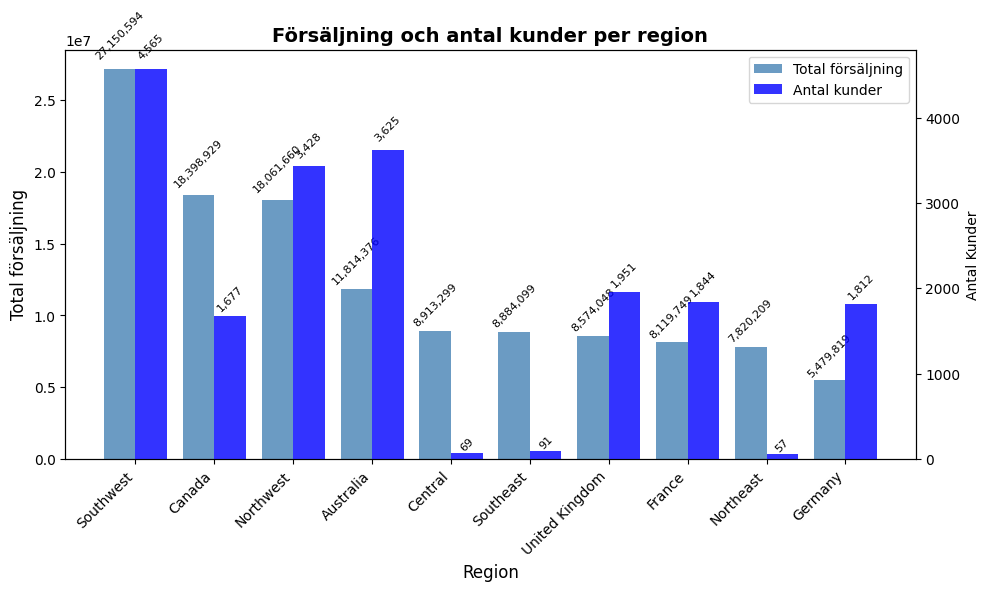

In [8]:
query_vis6 = """
SELECT 
    st.Name AS Regions,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT sc.CustomerID) AS TotalClients 
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh
    ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.Customer sc
    ON soh.CustomerID = sc.CustomerID
GROUP BY st.Name
ORDER BY SUM(soh.TotalDue) DESC;
"""
df_vis6 = query_df(query_vis6)



fig, ax1 = plt.subplots(figsize=(10,6))
width = 0.40

x = np.arange(len(df_vis6))
labels = df_vis6['Regions']

ax1.bar(x - width/2, df_vis6['TotalSales'],width, color= 'steelblue', alpha=0.8, label='Total försäljning')

ax1.set_ylabel('Total försäljning', fontsize=12)
ax1.set_xlabel('Region', fontsize=12)
ax1.set_title('Försäljning och antal kunder per region', fontsize=14, fontweight = 'bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis6['Regions'], ha='right', rotation=45)

ax2 = ax1.twinx()

ax2.bar(x + width/2, df_vis6['TotalClients'], width, color= 'blue', alpha=0.8, label='Antal kunder')
ax2.set_ylabel('Antal Kunder')

for xi, val in zip(x - width/2, df_vis6['TotalSales']):
    ax1.text(
        xi, val + val*0.02, 
        f'{int(val):,}', 
        ha='center', 
        va='bottom', 
        fontsize=8,
        rotation=45
        )
    
for xi, val in zip(x + width/2, df_vis6['TotalClients']):
    ax2.text(
        xi, val + val*0.02, 
        f'{int(val):,}',
        ha='center',
        va='bottom', 
        fontsize=8,
        rotation=45
        )


handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2)

plt.tight_layout()
plt.show()

### Insikter - Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Den starkaste regionen när det kommer till både försäljning och antal kunder är Southwest som leder med 27 150 594 i total försäljning och 4 565 kunder. 
För resterande regioner verkar det inte vara samma tydliga korrelation mellan kunder och försäljningssiffror. Om vi tittar på dem regionerna som ligger omkring 8 000 000 (Central, Southeast, United Kindom, France, Northeast) ser man stor variation på antalet kunder - var som helst mellan 69-1 951. Så ingen tydlig trend mellan ordervärde och antal kunder. Rekommenderar djupare studier i det här området. 

## Visulisering 7: Genomsnittligt ordervärde per region och kundtyp

Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

Tabeller som använts:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer
- Sales.Store

Plan:
- JOINA tabellerna
- Summera total försäljning delat på antal ordrar för varje kundtyp(privat/företag)
- Räkna ihop total försäljning delat på totalt antal kunder så resultat kan sorteras på det. 
- Skapa grupperat stapeldiagram
- Analysera resultatet

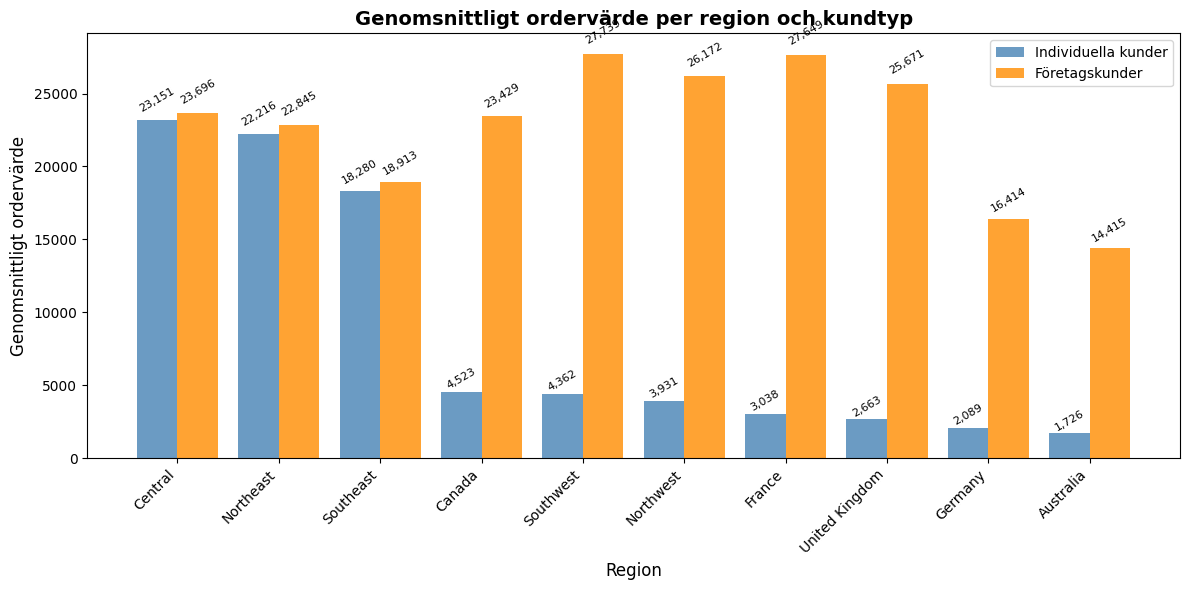

In [9]:
query_vis7 = """
SELECT
    st.Name AS Region,
    SUM(CASE WHEN sc.PersonID IS NOT NULL THEN so.TotalDue END)
    / NULLIF(COUNT(CASE WHEN sc.PersonID IS NOT NULL THEN so.SalesOrderID END),0)
    AS AvgOrderValue_Individual,
    SUM(CASE WHEN sc.StoreID IS NOT NULL THEN so.TotalDue END)
    / NULLIF(COUNT(CASE WHEN sc.StoreID IS NOT NULL THEN so.SalesOrderID END),0)
    AS AvgOrderValue_Store,
    SUM(so.TotalDue) * 1.0 / COUNT(so.SalesOrderID) AS AvgOrderValue_Total
FROM Sales.SalesTerritory st 
INNER JOIN Sales.SalesOrderHeader so
    ON st.TerritoryID = so.TerritoryID
INNER JOIN Sales.Customer sc
    ON so.CustomerID = sc.CustomerID
LEFT JOIN Sales.Store s
    ON sc.StoreID = s.BusinessEntityID
GROUP BY st.Name
ORDER BY AvgOrderValue_Total DESC;   
"""
df_vis7 = query_df(query_vis7)

fig, ax = plt.subplots(figsize=(12,6))
width = 0.40

x = np.arange(len(df_vis7))
labels = df_vis7['Region']

ax.bar(x - width/2, df_vis7['AvgOrderValue_Individual'],width, color= 'steelblue', alpha=0.8, label='Individuella kunder')
ax.bar(x + width/2, df_vis7['AvgOrderValue_Store'], width, color='darkorange', alpha=0.8, label='Företagskunder')

ax.set_ylabel('Genomsnittligt ordervärde', fontsize=12)
ax.set_xlabel('Region', fontsize=12)
ax.set_title('Genomsnittligt ordervärde per region och kundtyp', fontsize=14, fontweight = 'bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, ha='right', rotation=45)

for xi, val in zip(x - width/2, df_vis7['AvgOrderValue_Individual']):
    ax.text(
        xi, val + val*0.02, 
        f'{int(val):,}', 
        ha='center', 
        va='bottom', 
        fontsize=8,
        rotation=30
        )
    
for xi, val in zip(x + width/2, df_vis7['AvgOrderValue_Store']):
    ax.text(
        xi, val + val*0.02, 
        f'{int(val):,}',
        ha='center',
        va='bottom', 
        fontsize=8,
        rotation=30
        )


ax.legend()

plt.tight_layout()
plt.show()

### Insikter - Genomsnittligt ordervärde per region och kundtyp

Det är utan undantag företagskunder som har högst ordervärde igenom alla regioner. 
Central, Northeast och Southeast har dem högst siffrorna på individuella kunder men är ändå mindre än företagskunderna. 
Med tanke på att företagets fokus ligger på Bikes och components är det möjligt att individer köper mest av detta i regioner som inte har lika mycket val till kollektivtraffik. I länder med kollektivtraffik som Germany, United Kingdom, etc. är det mer företag som köper dessa. Kan också handla om kulturella skillnader i val mellan motorcyklar och bilanvändning.
Dessa skillnader pekar på oforskade marknader i dem regioner där privatkunder ligger lågt - en möjlighet att utreda anledningen till skillnaderna och vad för alternativ som kan skapas från företaget. 

# Visulisering för VG: Regional försäljningsoptimering (Alternativ A)

## Analysfrågor:
### 1. Vilken region presterar bäst/sämst?

Tabeller som använts:

- Sales.SalesTerritory
- Sales.SalesOrderHeader

Plan:

- JOINA tabellerna
- Summera total försäljning 
- Gruppera total försäljning enligt regioner 
- Sortera enligt försäljning 
- Skapa ett stapeldiagram
- Analysera resultatet



### 2. Vilka produktkategorier säljer bäst var?

Tabeller som använts:

- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail
- Sales.SalesOrderHeader
- Sales.SalesTerritory

Plan:

- JOINA tabellerna
- Summera total försäljning 
- Gruppera total försäljning enligt kategorinamn och regioner 
- Sortera enligt försäljning 
- Skapa en heatmap region×kategori
- Analysera resultatet

### 3. Finns säsongsmönster per region?

Tabeller som använts:

- Sales.SalesTerritory
- Sales.SalesOrderHeader

Plan:

- JOINA tabellerna
- Summera total försäljning
- Formatera om datumen till mer hanterbart format för visualisering 
- Gruppera total försäljning enligt region och datum 
- Sortera enligt region och datum 
- Skapa ett linjediagram 
- Analysera resultatet

### 4.  Rekommendationer för förbättring?



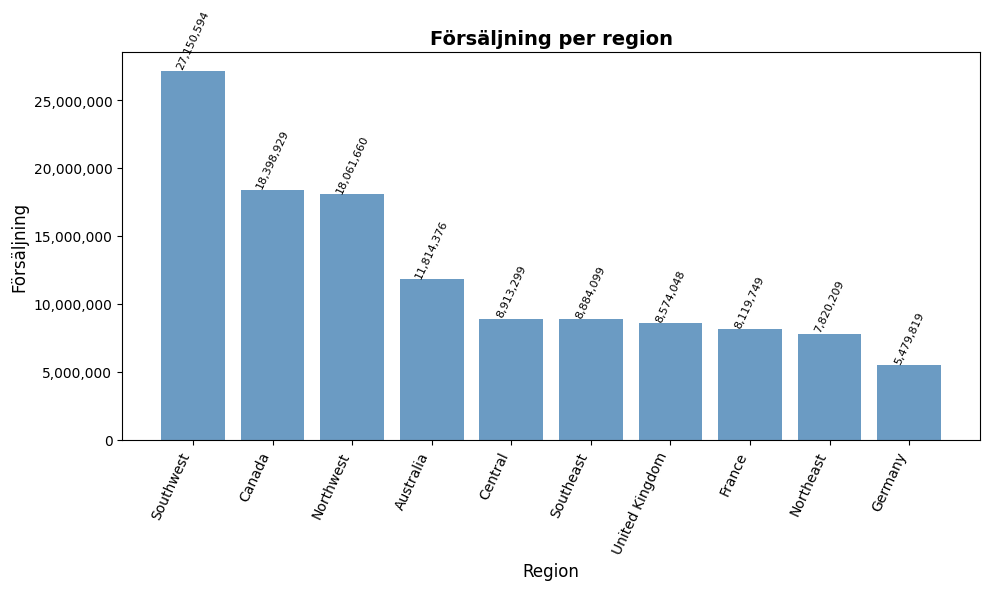

C:\Users\Mauro\AppData\Local\Temp\ipykernel_26344\1542746457.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = pivot.applymap(human_format)


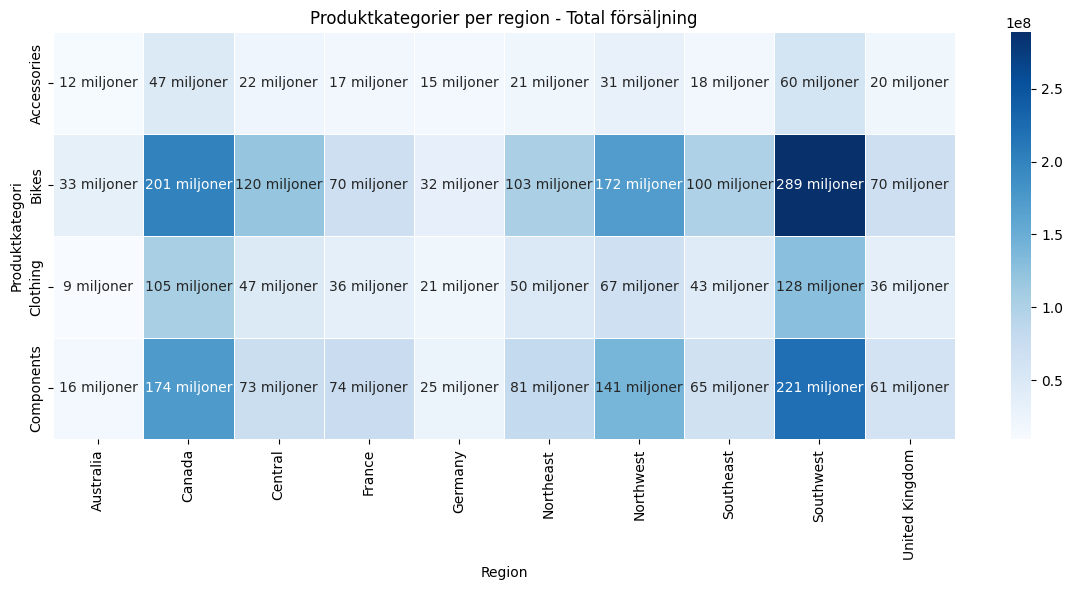

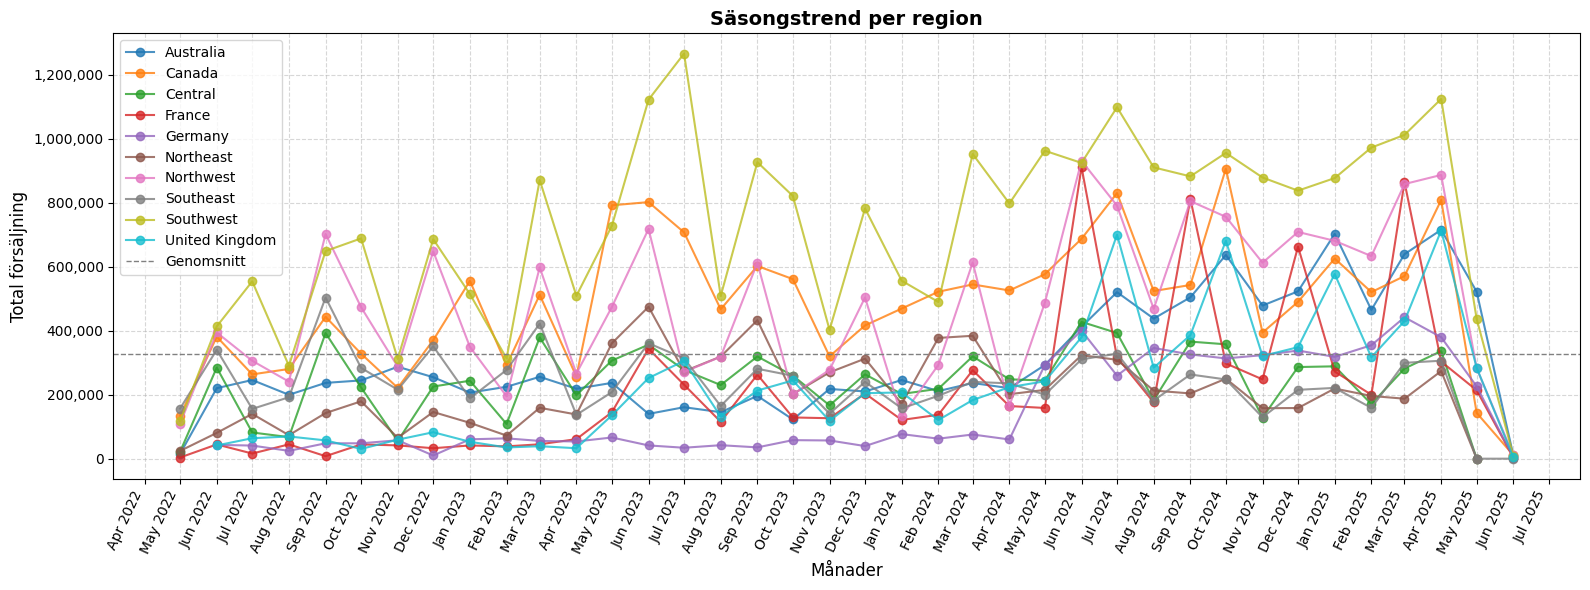

C:\Users\Mauro\AppData\Local\Temp\ipykernel_26344\1542746457.py:206: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = pivot.applymap(percent_format)


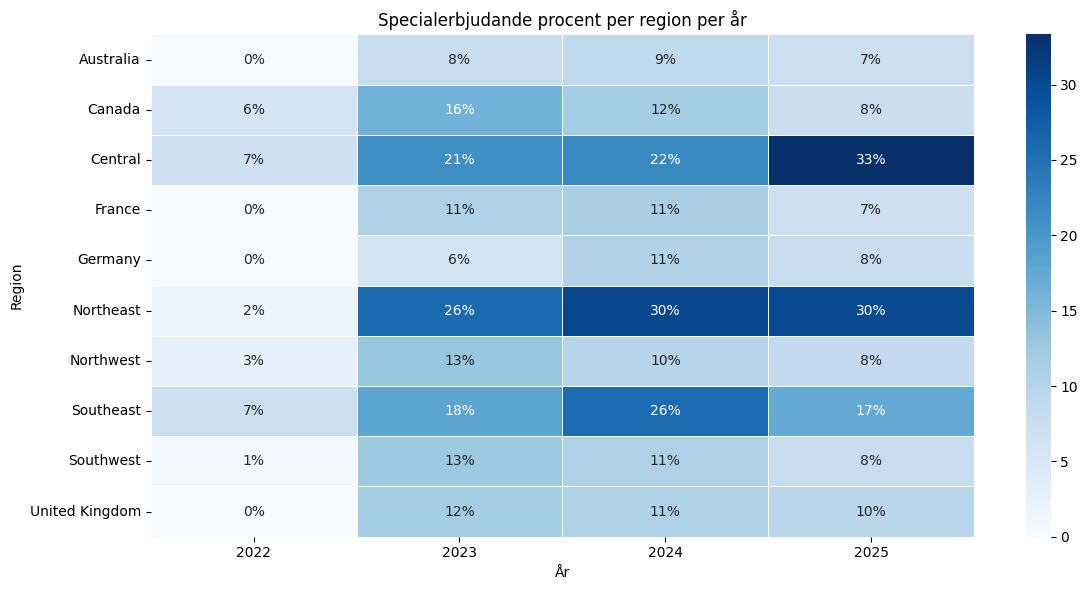

Year,2022,2023,2024,2025
Region,,,,
Australia,0.00,8.10,8.92,7.31
Canada,5.92,16.14,11.79,7.66
Central,7.02,21.14,21.85,33.33
France,0.00,10.69,11.23,7.18
Germany,0.00,6.02,10.52,7.82
Northeast,1.89,25.93,30.43,30.19
Northwest,2.93,13.13,9.95,8.50
Southeast,7.32,18.06,25.56,17.39
Southwest,1.12,12.52,10.68,8.04


In [ ]:
#Vilken region presterar bäst/sämst? -> stapeldiagram

query_vis8 = """
SELECT 
    st.Name AS Regions,
    SUM(soh.TotalDue) AS TotalSales
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh
    ON st.TerritoryID = soh.TerritoryID
GROUP BY st.Name
ORDER BY SUM(soh.TotalDue) DESC;  
"""
df_vis8 = query_df(query_vis8)


fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(df_vis8['Regions'], df_vis8['TotalSales'], color= 'steelblue', alpha=0.8)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'))
fig.autofmt_xdate(rotation=65)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height):,}',
        ha='center',
        va='bottom',
        fontsize=8,
        rotation=65
    )

 

ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Försäljning', fontsize=12)
ax.set_title('Försäljning per region', fontsize=14, fontweight = 'bold')

plt.tight_layout()
plt.show()


#----------------------------------------------------------------------
#Vilka produktkategorier säljer bäst var? -> heatmap region×kategori

query_vis9 = """
SELECT 
    pc.Name AS CategoryName,
    st.Name AS Regions,
    SUM(soh.TotalDue) AS TotalSales    
FROM Production.ProductCategory pc
LEFT JOIN Production.ProductSubcategory ps
    ON pc.ProductCategoryID = ps.ProductCategoryID
INNER JOIN Production.Product p
    ON ps.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail so
    ON p.ProductID = so.ProductID
INNER JOIN Sales.SalesOrderHeader soh
    ON so.SalesOrderID = soh.SalesOrderID
INNER JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
GROUP BY pc.Name, st.Name
ORDER BY TotalSales;
"""
df_vis9 = query_df(query_vis9)

pivot = df_vis9.pivot(index="CategoryName", columns="Regions", values="TotalSales")

def human_format(num):
    for unit in ['', ' tusen', ' miljoner', ' miljarder']:
        if abs(num) < 1000:
            return f"{num:.0f}{unit}"
        num /= 1000
    return f"{num:.0f} miljarder"
annot_matrix = pivot.applymap(human_format)

fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(
    pivot, 
    annot=annot_matrix,
    fmt="",             
    linewidth=.5, 
    cmap="Blues")

plt.title("Produktkategorier per region - Total försäljning")
plt.xlabel("Region")
plt.ylabel("Produktkategori")
plt.tight_layout()
plt.show()



#----------------------------------------------------------------------
#Finns säsongsmönster per region? -> linjediagram säsongsmönster

query_vis10 = """
SELECT
    st.Name AS Region,
    CAST(FORMAT(soh.OrderDate, 'yyyy-MM-01') AS date) AS MonthStart,
    SUM(soh.TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
GROUP BY
    st.Name,
    FORMAT(soh.OrderDate, 'yyyy-MM-01')
ORDER BY
    st.Name,
    MonthStart;
"""
df_vis10 = query_df(query_vis10)


fig, ax = plt.subplots(figsize=(16,6))


for region, group in df_vis10.groupby("Region"):
    ax.plot(
        group["MonthStart"],
        group["TotalSales"],
        marker='o',
        linestyle='-',
        alpha=0.8,
        label=region
    )


ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=65)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'))

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Månader', fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12)
ax.set_title('Säsongstrend per region', fontsize=14, fontweight = 'bold')

avg_sales = df_vis10['TotalSales'].mean()
ax.axhline(avg_sales, color='gray', linestyle='--', linewidth=1, label='Genomsnitt')

ax.legend()

plt.tight_layout()
plt.show()

#----------------------------------------------------------------------
#Pivot tabell med förbättringsmöjligheter?

query_vis11 = """
WITH TotalSalesPerYear AS (
    SELECT 
        st.Name AS Region,
        YEAR(soh.OrderDate) AS Year,
        COUNT(*) AS TotalOrders
    FROM Sales.SalesOrderHeader soh
    INNER JOIN Sales.SalesTerritory st
        ON soh.TerritoryID = st.TerritoryID
    GROUP BY st.Name, YEAR(soh.OrderDate)
),
SpecialOfferSales AS (
    SELECT 
        st.Name AS Region,
        YEAR(soh.OrderDate) AS Year,
        COUNT(DISTINCT soh.SalesOrderID) AS SpecialOfferOrders,
        SUM(DISTINCT soh.TotalDue) AS SpecialOfferSales
    FROM Sales.SalesOrderDetail sod
    INNER JOIN Sales.SalesOrderHeader soh
        ON sod.SalesOrderID = soh.SalesOrderID
    INNER JOIN Sales.SalesTerritory st
        ON soh.TerritoryID = st.TerritoryID
    WHERE sod.SpecialOfferID <> 1   
    GROUP BY st.Name, YEAR(soh.OrderDate)
)
SELECT
    t.Region,
    t.Year,
    COALESCE(s.SpecialOfferOrders, 0) AS SpecialOfferOrders,
    t.TotalOrders,
    CAST(
        COALESCE(s.SpecialOfferOrders, 0) * 100.0 / t.TotalOrders 
        AS DECIMAL(5,2)
    ) AS PercentageWithSpecialOffer,
    COALESCE(s.SpecialOfferSales, 0) AS SpecialOfferSales
FROM TotalSalesPerYear t
LEFT JOIN SpecialOfferSales s
    ON t.Region = s.Region
   AND t.Year = s.Year
ORDER BY t.Year, t.Region;
"""
df_vis11 = query_df(query_vis11)


pivot = df_vis11.pivot(
    index="Region",
    columns="Year",
    values="PercentageWithSpecialOffer"
)


def percent_format(x):
    return f"{x:.0f}%"
annot_matrix = pivot.applymap(percent_format)

fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(
    pivot, 
    annot=annot_matrix,
    fmt="",             
    linewidth=.5, 
    cmap="Blues")

plt.title("Specialerbjudande procent per region per år")
plt.xlabel("År")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

pivot

## Insikter - Regional försäljningsoptimering

Analysfrågor:
- Vilken region presterar bäst/sämst?
- Vilka produktkategorier säljer bäst var?
- Finns säsongsmönster per region?
- Rekommendationer för förbättring?


Southwest ligger på topp med högsta siffrorna I juni-juli under 2023-2024. 2025 kan vi tyvärr inte räkna då vi inte har hela årets data. Trenden syns även I flera andra regioner som Canada, Northwest, France, Northeast, m.m.
I visualisering n.2 ser vi att Bikes och Components är dem högst säljande produktkategorierna - dem siffrorna matchas även I heatmap diagramet där Bikes säljer bäst I Southwest, Canada och Northwest. Components kommer I andra plats och säljs bäst I samma 3 regioner som Bikes. 
Lägst prestation har vi I Germany som har bland dem lägsta försäljningssiffrorna. För att få en bättre helhetsbild skulle vi ha behövt en bild av total population per region. Om antalen skiljer sig avsevärt skulle det gynna oss att se total försäljning vs antal I regionens population.
Om populationerna inte skiljer sig avsevärt skulle vi kunna se hur vi kan öka försäljningen I dem lägre presterande områdena såsom Germany och Northeast.

### Varför valde du denna djupanalys? Vad ville du undersöka?
Jag valde Regional försäljningsoptimering eftersom det är en av dem viktigaste frågorna som företag jobbar med dagligen och jag ville se vad jag kan lära mig igenom denna simulering.  Jag ville utreda hur mycket förbättringar man kan hitta utifrån den här datan och var man skulle behöva utföra djupare undersökningar för mer försäljningsoptimering.

### Varför valde du att göra aggregering i SQL vs pandas?
Aggregeringen gjordes I SQL eftersom datan fanns I databasen och jag ville minimera hur mycket data som behövde dras från SQL till Python. Det är väldigt många tabeller som sätts ihop och SQL är gjord för att optimera den sortens datahantering så lättast att använda det direkt I SQL istället för att överföra datan till Python och aggregera där. 

### Varför valde du dessa typer av diagram för djupanalysen?
För djupanalysen valde jag heatmap, linjediagram, stapeldiagram enligt nämnda rekommendationer I uppgiftsbeskrivningen men även för att det passade datan bäst. 
- heatmap var perfekt för att kunna analysera försäljning utifrån regioner och produktkategorier.
- linjediagram är ju perfekt för att visualisera kontinuerlig data som förändras över tid så var det självklara valet.
- Jag valde ett vanligt stapediagram för första frågan istället för ett grupperat stapeldiagram eftersom det inte fanns något behov för detta.

### Hur hjälpte pivot tables dig att se mönster i data?
Med tanke på hur försäljningen skilldes mellan dem olika regionerna ville jag se om specialerbjudanden hade påverkat försäljningen I dem olika områdena. Jag skapade initiellt en pivottabell som visade specialerbjudanden samt total försäljning - detta visade direkt att jag behövde få en djupare inblick i hur stor del av totalförsäljningen faktiskt inkluderade specialerbjudanden. Jag ändrade då målet till att visa procent av försäljningen med specialerbjundande enligt år. Såg då att år nog inte räcker för att påvisa regional variation så inkluderade även regioner. Pivot tables är fantastiska för att hitta mönster och visa där datan brister.   

### Vilka utmaningar stötte du på och hur löste du dem?
Första hindret blev att försöka komma fram till vilken procentsats av försäljningen som hade inkluderat specialerbjudanden - efter att ha joinat tabellerna fick jag skapa subqueries som kunde visa både totalförsäljning samt försäljningen med specialerbjudanden. 
Genom INNER JOIN försökte jag filtrera så att siffrorna under "SpecialOfferSales" bara visade försäljningen med specialerbjudanden - fick först fram samma siffra som totalförsäljningen så inkluderade raden "WHERE sod.SpecialOfferID <> 1 " för att garantera detta. 
Största utmaningen för mig var att klura ut hur jag skulle få ut Specialerbjudandens procentsats utifrån totala köp men efter flera försök använde jag denna kalkylering som även löste problemet med NULL: COALESCE(s.SpecialOfferOrders, 0) * 100.0 / t.TotalOrders

Ett annat hinder var att försöka läsan datan utifrån bara pivot tabellen - det var inte så tydligt  som du kan se ovan så skapade en heatmap med datan istället. 
Med tanke på den låga försäljningen antog jag att Germany skulle ha haft en högre andel specialerbjundanden per försäljning men diagramet visar att Germany har konstant låg andel specialerbjundanden. Detta är något som skulle kunna investeras mer I för att öka försäljningen. 

### Vilka konkreta rekommendationer ger din djupanalys?
Min rekommendation för framtiden är en djupare analys av försäljningssiffror I jämförelse med regionens population för att se om det är proportioneligt.
Samt mer investering I specialerbjudanden och andra lokaliserade erbjudanden I Germany och andra regioner med låg försäljning.